# Exploring Test Data
4 features, Unsupervised, Clustering

# Loading data

In [1]:
from scipy.io import loadmat
import pandas as pd

In [2]:
water = loadmat('OrderParam_Run06_swm4ndp_T30.0_1709121803.mat')

In [3]:
water.keys()

dict_keys(['__header__', '__version__', '__globals__', 'q_all', 'r', 'Q6_all', 'LSI_all', 'Sk_all', 'g_r'])

In [4]:
print(len(water['q_all'][3]))
print(len(water['r'][0]))
print(len(water['Q6_all'][0]))
print(len(water['LSI_all'][0]))
print(len(water['Sk_all'][0]))
print(len(water['g_r'][0]))

512
240
512
512
512
240


r and g_r has less data. I am only using q_all, Q6_all, LSI_all, Sk_all.

## Collapsing data into 1 column 

In [5]:
q_all = []
for i in range(0,len(water['q_all'])): 
    q_all.extend(water['q_all'][i])
Q6_all = []
for i in range(0,len(water['Q6_all'])): 
    Q6_all.extend(water['Q6_all'][i])
LSI_all = []
for i in range(0,len(water['LSI_all'])): 
    LSI_all.extend(water['LSI_all'][i])
Sk_all = []
for i in range(0,len(water['Sk_all'])): 
    Sk_all.extend(water['Sk_all'][i])

In [6]:
print(len(q_all))
print(len(Q6_all))
print(len(LSI_all))
print(len(Sk_all))

512000
512000
512000
512000


In [7]:
data = {'q_all': q_all, 
        'Q6_all': Q6_all,
        'LSI_all': LSI_all,
        'Sk_all': Sk_all
        }

In [8]:
df_try = pd.DataFrame(data = data)

In [9]:
df_try.head()

,q_all,Q6_all,LSI_all,Sk_all
0,0.586487,0.376439,0.000086,0.998859
1,0.614793,0.184714,0.000124,0.999004
2,0.693650,0.271328,0.001445,0.999722
3,0.627313,0.351191,0.000239,0.999468
4,0.428856,0.217197,0.000271,0.999823


# Processsing Data

In [10]:
from sklearn import preprocessing, cluster, metrics
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# one way to normalize
x = df_try.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled= min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns = data.keys())

In [12]:
df_scaled.head()

,q_all,Q6_all,LSI_all,Sk_all
0,0.728302,0.720311,0.019661,0.910666
1,0.746934,0.253288,0.028441,0.922000
2,0.798840,0.464271,0.331501,0.978253
3,0.755175,0.658809,0.054795,0.958347
4,0.624545,0.332414,0.062211,0.986149


In [13]:
# another way to normalize
df_scaled2 = scale(df_try)

In [14]:
df_scaled2[0]

array([-0.18739625,  2.34230312, -0.76003024, -0.07799382])

## PCA 

In [15]:
df_scaled.values

array([[0.72830208, 0.72031077, 0.01966137, 0.91066583],
       [0.74693412, 0.25328781, 0.02844091, 0.9219996 ],
       [0.79883988, 0.46427119, 0.33150111, 0.97825308],
       ...,
       [0.78494334, 0.64890481, 0.04067266, 0.87831099],
       [0.6880323 , 0.40691654, 0.21509063, 0.83684972],
       [0.64987189, 0.56940196, 0.02446462, 0.87223823]])

In [16]:
# Create a Randomized PCA model that takes two components
randomized_pca = PCA(n_components=2, svd_solver='randomized')

# Fit and transform the data to the model
reduced_data_rpca = randomized_pca.fit_transform(df_scaled)

# Inspect the shape
print(reduced_data_rpca.shape)

# Print out the data
print(reduced_data_rpca)

(512000, 2)
[[-0.00544328  0.27446683]
 [ 0.03213937 -0.19150006]
 [-0.09419576  0.00460868]
 ...
 [-0.04477854  0.19704364]
 [ 0.06778344 -0.03313527]
 [ 0.09741769  0.13530106]]


In [17]:
# Create a regular PCA model 
pca = PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(df_scaled)

# Inspect the shape
print(reduced_data_pca.shape)

# print out data
print(reduced_data_pca)

(512000, 2)
[[-0.00544328  0.27446683]
 [ 0.03213937 -0.19150006]
 [-0.09419576  0.00460868]
 ...
 [-0.04477854  0.19704364]
 [ 0.06778344 -0.03313527]
 [ 0.09741769  0.13530106]]


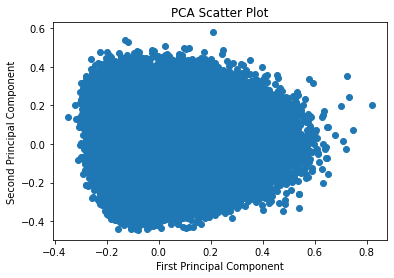

In [18]:
# Building Scatterplot to visualise data
plt.scatter(reduced_data_rpca[:, 0], reduced_data_rpca[:, 1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

There is no clear separation.

## Check the number of clusters to make with KMeans

### Elbow method
Based on the sum of squared distance (SSE)to check the best number of clusters 

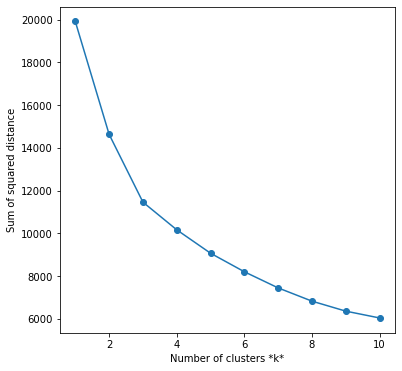

In [19]:
sse = []
list_k = list(range(1,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(df_scaled)
    sse.append(km.inertia_)
    
# Plot sse against k
plt.figure(figsize=(6,6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
    

### Silhouette Coefficient
Based on the:
a: The mean distance between a sample and all other points in the same class.
b: The mean distance between a sample and all other points in the next nearest cluster.

s = (b - a) / max(a,b)

The higher the Silhouette Coeffeicent score, the more defined is the cluster

In [20]:
# md = mean distance
# minimum number of clusters is 2

md = []
list_k = list(range(2,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42).fit(df_scaled)
    labels = km.labels_
    md.append(metrics.silhouette_score(df_scaled, labels, metric='euclidean'))
    
# Plot md against k
plt.figure(figsize=(6,6))
plt.plot(list_k, md, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette Coefficient');
    

KeyboardInterrupt: 

### Calinski-Harabasz Index 
The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared).

also known as the Variance Ratio Criterion.

higher score = model with better defined clusters

In [ ]:
ch = []
list_k = list(range(2,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42).fit(df_scaled)
    labels = km.labels_
    ch.append(metrics.calinski_harabasz_score(df_scaled, labels))
    
# Plot md against k
plt.figure(figsize=(6,6))
plt.plot(list_k, ch, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('CH Score');

### Davies Bouldin Index 
This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

lower davies-Bouldin indec relates to a model with a better separation between clusters

In [ ]:
db = []
list_k = list(range(2,11))

for k in list_k: 
    km = cluster.KMeans(init='k-means++', n_clusters=k, random_state=42).fit(df_scaled)
    labels = km.labels_
    db.append(metrics.davies_bouldin_score(df_scaled, labels))
    
# Plot md against k
plt.figure(figsize=(6,6))
plt.plot(list_k, db, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('CH Score');

## Scatterplot Matrix
To check relationship between 2 variables

In [28]:
import seaborn as sns
from time import time

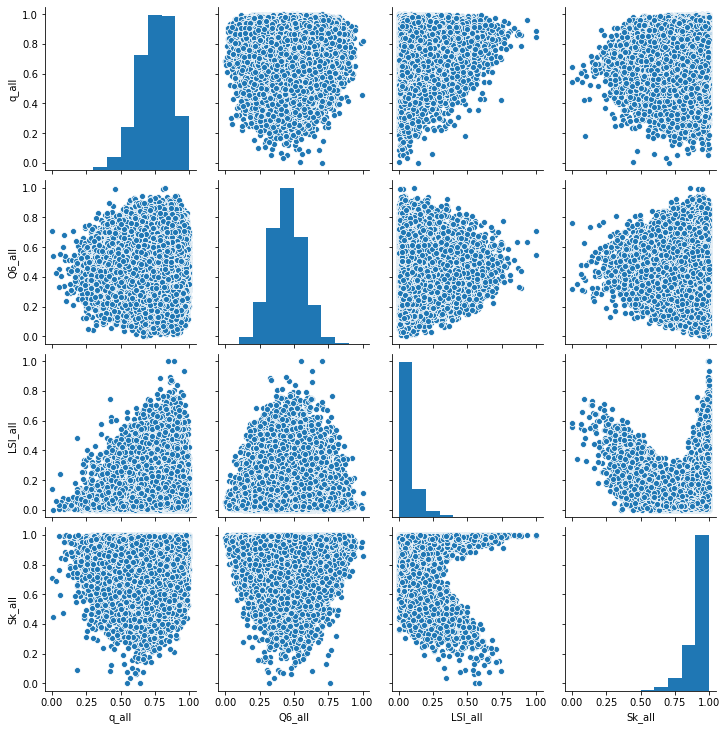

In [20]:
# without clustering
sns.pairplot(df_scaled)

KMeans: 1.7 sec


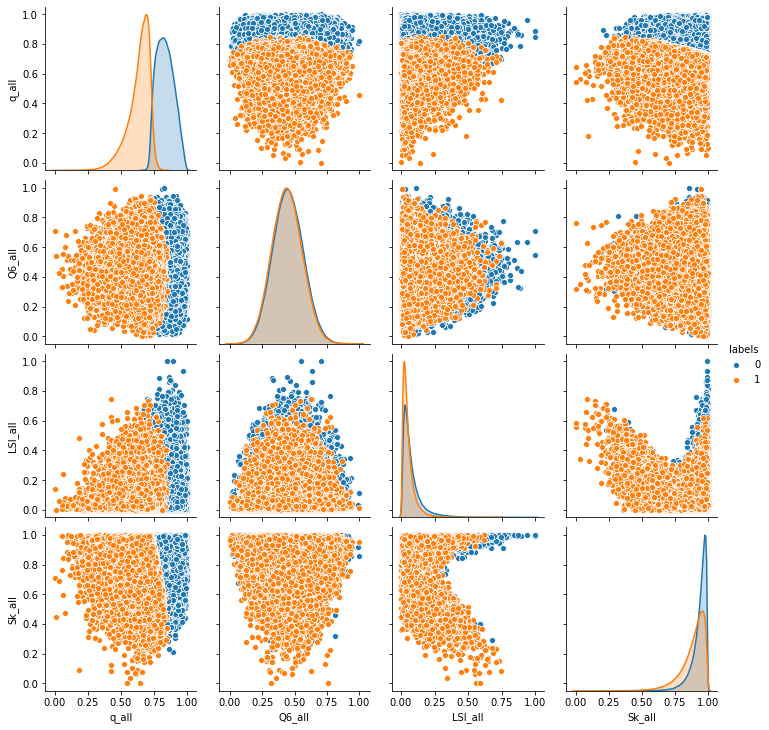

In [29]:
# with clustering from KMeans
t0 = time()
km = cluster.KMeans(init='k-means++', n_clusters=2, random_state=42).fit(df_scaled)
t1 = time()
print("KMeans: %.2g sec" % (t1-t0))
labels = km.labels_ 
plotdata = {'q_all': df_scaled['q_all'], 
            'Q6_all': df_scaled['Q6_all'],
            'LSI_all': df_scaled['LSI_all'],
            'Sk_all': df_scaled['Sk_all'],
            'labels': labels
            }
df_plot = pd.DataFrame(data = plotdata)
sns.pairplot(df_plot, hue = 'labels')

(512000, 2)
[[-0.00544328  0.27446683]
 [ 0.03213937 -0.19150006]
 [-0.09419576  0.00460868]
 ...
 [-0.04477854  0.19704364]
 [ 0.06778344 -0.03313527]
 [ 0.09741769  0.13530106]]


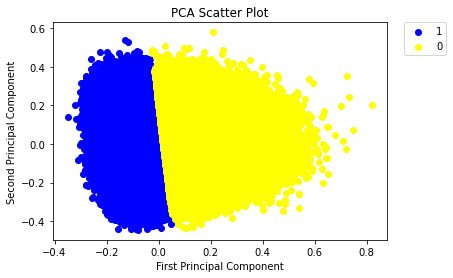

In [22]:
# using PCA

# Create a regular PCA model 
pca = PCA(n_components=2)

# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(df_scaled)

# Inspect the shape
print(reduced_data_pca.shape)

# print out data
print(reduced_data_pca)

# Building Scatterplot to visualise data
colors = ['blue', 'yellow']
for i in range(len(colors)):
    x = reduced_data_rpca[:, 0][labels == i]
    y = reduced_data_rpca[:, 1][labels == i]
    plt.scatter(x, y, c=colors[i])
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

## Using TSNE

In [24]:
from sklearn.manifold import TSNE

In [27]:
tsne_model = TSNE(n_components=2, init = 'pca', random_state = 0).fit_transform(df_scaled)

KeyboardInterrupt: 